<a href="https://colab.research.google.com/github/cdmurray80/object_detection/blob/main/factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [126]:

#
# Helper functions
#
# Given covariance, compute correlation
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    return correlation

#Given covariance and loadings, compute variance.
#If loadings represent differences from target, this will return tracking variance
def compute_variance(cov, loadings):
  return(np.matmul(loadings.transpose(),np.matmul(cov, loadings))[0,0])


In [127]:
#
# CHANGE THIS AS YOU SEE FIT
#
# Create our covariance matrix
cov_diag_term = .6
cov = np.matrix([[2.0,cov_diag_term],[cov_diag_term,1.3]]);

#
# Sanity check, and show 
assert(cov_diag_term < (cov[0,0]*cov[1,1])**0.5)
cor = correlation_from_covariance(cov)
print('Covariance:\n', cov, '\nCorrelation:\n', cor)

Covariance:
 [[2.  0.6]
 [0.6 1.3]] 
Correlation:
 [[1.        0.3721042]
 [0.3721042 1.       ]]


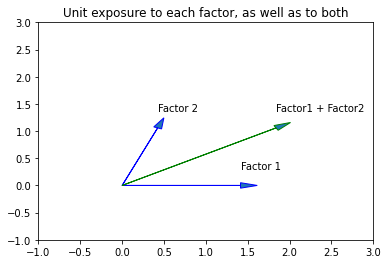

In [128]:
def arrow_w_title(plt_ax, x, y, title, edg_color='b'):
  plt_ax.arrow(0,0,x,y, head_length = 0.2, head_width=0.1, edgecolor=edg_color)
  plt_ax.annotate(title, xy=(x,y+0.3))

#
# Plot vectors to show risk of unit exposure to either factor
ax = plt.axes()
unit_var = compute_variance(cov, np.matrix([[1.],[1.]]))
arrow_w_title(ax, cov[0,0]**0.5,0, 'Factor 1')

# This is a bit subtle...we use the covariance to scale our plot so that the
# length of a vector with unit exposure to each factor is the risk of 
# unit exposure that each factor.
#factor_2_dx = (unit_var - cov[1,1])**0.5 - cov[0,0]**0.5
factor_2_dx = (unit_var - cov[0,0] - cov[1,1])/(2*(cov[0,0]**0.5))
factor_2_dy = (cov[1,1] - factor_2_dx**2)**0.5
arrow_w_title(ax, factor_2_dx,factor_2_dy, 'Factor 2')
arrow_w_title(ax, cov[0,0]**0.5 + factor_2_dx,factor_2_dy, 'Factor1 + Factor2', edg_color='g')
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
plt.title('Unit exposure to each factor, as well as to both')
plt.show()

In [129]:
# Sanity check that the risk of unit exposure to each factor equals the plotted L2 norm
print('Risk: {:.5f}, L2 Norm: {:.5f}'.format( unit_var ** 0.5, ((cov[0,0]**0.5 + factor_2_dx)**2 + factor_2_dy**2)** 0.5))

Risk: 2.12132, L2 Norm: 2.12132


Eigenvalue  0 :
Value: 2.3446221994724903 
Vector:
 [[0.86714215]
 [0.49806073]] 


Eigenvalue  1 :
Value: 0.9553778005275098 
Vector:
 [[-0.49806073]
 [ 0.86714215]] 




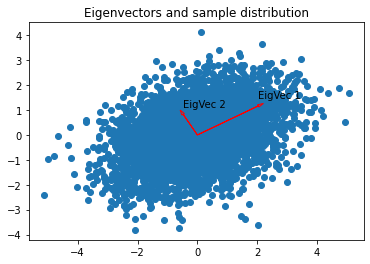

In [130]:
#Do eigen decomposition...annoying but we need exrta code to sort eigenvectors so it's more than 1 line
# Probably 95% of users want the result sorted...idk why it's not an argument to return in sorted order
eigenvalues, eigenvectors = np.linalg.eig(cov)
idx = (eigenvalues).argsort()[::-1]   
eigenvectors = eigenvectors[:,idx]
eigenvalues = eigenvalues[idx]

# Plot samples and eigenvectors
samples=np.random.multivariate_normal(np.array([0,0]),cov, size=4000)
ax=plt.axes()
plt.scatter(samples[:,0],samples[:,1])

for i in range(2):
  arrow_w_title(ax, eigenvectors[0,i]*eigenvalues[i],eigenvectors[1,i]*eigenvalues[i], 'EigVec ' + str(i+1), edg_color='r')
  print( 'Eigenvalue ', i, ':\nValue:', eigenvalues[i], '\nVector:\n', eigenvectors[:,i],'\n\n')
plt.title('Eigenvectors and sample distribution')
plt.show()

Factor transformation:  [ 1. -1.] --> [[ 0.86535651 -1.30428452]]


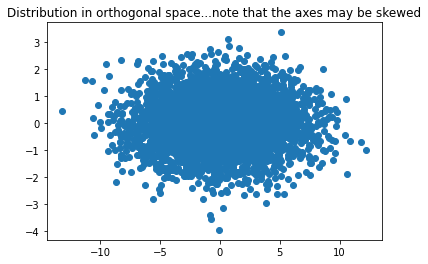

In [132]:
# Now the orthogonal factors are simply the eigenvectors times the raw factors...here I make up 'raw' factor loadings and compute 'orthogonalized' loadings
# Annoyingly you have to transpose the eigenvector matrix

#
# CHANGE NUMBERS HERE IF YOU WANT
raw_factor_loadings = np.array([1.,1.])

# Here the orthogonalized factors are constructed to have unit variance, so the exposure is much larger in the first factors because it captures most variance
orthogonlized_factor_loadings = np.multiply(eigenvalues,np.matmul(eigenvectors.transpose(), raw_factor_loadings))
print('Factor transformation: ', raw_factor_loadings, '-->', orthogonlized_factor_loadings)
orthogonalized_samples = np.matmul(eigenvectors.transpose(), samples.transpose()).transpose()
orthogonalized_samples = np.multiply(orthogonalized_samples, eigenvalues)
# Use .A1 to get as an array
plt.scatter(orthogonalized_samples[:,0].A1,orthogonalized_samples[:,1].A1)
plt.title('Distribution in orthogonal space...note that the axes may be skewed')
plt.show()
